# Amazon Fine Food Reviews

This notebook follows [this article](https://datascienceplus.com/scikit-learn-for-text-analysis-of-amazon-fine-food-reviews/) on text classification for predicting positivity using Scikit-Learn.

### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samcoffey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/samcoffey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Setup

In [2]:
#--------------------------------------------------------------------------------
# Set DATA_LOCAL to True if data is stored locally in '/data', otherwise set False
# and file will be downloaded from S3
#
# NOTE: Importing data from URL will take ~15-20s
#
#
DATA_LOCAL = True
LOCAL_PATH = "../data/"
REMOTE_PATH = "https://s3.amazonaws.com/coetichr/AmazonFoodReviews/"
DROP_COLS = ["ProductId", "UserId", "ProfileName", "Time", "Summary", "HelpfulnessDenominator", "HelpfulnessNumerator"]

# Plotting the token distributions takes a while, set PLOT_TOKEN_DIST to False to skip over them
PLOT_TOKEN_DIST = False

def load_data(file, nrows = -1):
    path = LOCAL_PATH if DATA_LOCAL else REMOTE_PATH
    if (nrows > -1):
        return pd.read_csv(path + file, nrows = nrows)
    else:
        return pd.read_csv(path + file)
#
#
#--------------------------------------------------------------------------------

### Helper Methods

In [3]:
# Tokens that appear frequently that should be stripped
remove_tokens = ['br', 'br br', 'it s', 'br i']

def countplot(df, xcol, title = 'Distribution'):
    sns.countplot(x=xcol, data=df, palette="GnBu_d").set_title(title)
    plt.show()
    
def count_positive(data):
    return data[data['Score'] > 3].shape[0]

def compute_avg(data):
    return np.mean(list(map(lambda s: float(s), data.loc[:, "Score"])))

def plot_confusion_matrix(model, xtest, ytest, preds):
    cm = confusion_matrix(ytest, preds)
    score = model.score(xtest, ytest)
    plt.figure(figsize = (9,9))
    sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = 'Blues_r')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    title = 'Accuracy Score: {0}'.format(score)
    plt.title(title, size = 15)

# Plot the given dataframe representing the distribution of token counts
def plot_token_df(token_df, title = 'Token Count Distribution'):
    plt.subplots(figsize = (14,10))
    sns.barplot(x = token_df['count'], y = token_df['token'], palette = "deep").set_title(title)
    plt.show()

# Sum the columns in the matrix and return the row of column sums
def sum_matrix(m):
    sums = []
    for col in range(len(m[0])):
        sum = 0
        for row in m:
            sum += row[col]
        sums.append(sum)
    return sums

# Remove rows from given data frame where the token column isn't a stopword
def remove_stopwords(tok_df):
    return tok_df[~tok_df.token.isin(stopwords.words('english'))]

# Remove rows from given data frame where token column isn't in given list
def remove_with_list(tok_df, tok_list):
    return tok_df[~tok_df.token.isin(tok_list)]

# Create a data frame of tokens and their counts from the given vectorizer
# and array of documents
def cv_to_df(train_vect, doc_arry):
    mtrx = train_vect.transform(doc_arry).toarray()
    feats = train_vect.get_feature_names()
    sums = sum_matrix(mtrx)
    cv_df = pd.DataFrame(data = { 'token': feats, 'count': sums })
    cv_df = remove_stopwords(cv_df)
    cv_df = remove_with_list(cv_df, remove_tokens)
    return cv_df.sort_values('count', ascending = False)

### Load  `Reviews.csv`

In [4]:
# Load Reviews.csv
review_data = load_data("Reviews.csv", 50000)

# Print the first 5 lines
print("Number of rows: " + str(review_data.shape[0]))
review_data.head()

Number of rows: 50000


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Makeup

How many helpful reviews are positive/negative? How many unhelpful reviews are positive/negative?

In [5]:
df = review_data.copy()

df_neutral = df[(df['HelpfulnessNumerator'] == 0) & (df['HelpfulnessDenominator'] == 0)]
df_helpful = df[df['HelpfulnessNumerator'] != 0]
df_unhelpful = df[(df['HelpfulnessNumerator'] == 0) & (df['HelpfulnessDenominator'] != 0)]

print("Distribution (neutral):          " + "{0:.2f}%".format((df_neutral.shape[0] / df.shape[0]) * 100.0))
print("Distribution (helpful):          " + "{0:.2f}%".format((df_helpful.shape[0] / df.shape[0]) * 100.0))
print("Distribution (unhelpful):        " + "{0:.2f}%".format((df_unhelpful.shape[0] / df.shape[0]) * 100.0))
print("")
print("Average score (overall):         " + "{0:.2f}".format(compute_avg(df)))
print("Average score (neutral):         " + "{0:.2f}".format(compute_avg(df_neutral)))
print("Average score (unhelpful):       " + "{0:.2f}".format(compute_avg(df_helpful)))
print("Average score (helpful):         " + "{0:.2f}".format(compute_avg(df_unhelpful)))
print("")
print("Percentage positive (overall):   " + "{0:.2f}%".format(float(count_positive(df))/float(df.shape[0])))
print("Percentage positive (neutral):   " + "{0:.2f}%".format(float(count_positive(df_neutral))/float(df_neutral.shape[0])))
print("Percentage positive (unhelpful): " + "{0:.2f}%".format(float(count_positive(df_unhelpful))/float(df_unhelpful.shape[0])))
print("Percentage positive (helpful):   " + "{0:.2f}%".format(float(count_positive(df_helpful))/float(df_helpful.shape[0])))

Distribution (neutral):          48.46%
Distribution (helpful):          45.72%
Distribution (unhelpful):        5.82%

Average score (overall):         4.15
Average score (neutral):         4.38
Average score (unhelpful):       4.01
Average score (helpful):         3.20

Percentage positive (overall):   0.77%
Percentage positive (neutral):   0.84%
Percentage positive (unhelpful): 0.47%
Percentage positive (helpful):   0.73%


# Positivity Approach - Logistic Regression

### Cleaning

#### Add Classification Column (Positivity)

- Remove rows with neutral score ('Score' = 3)
- Remove unhelpful reviews ('HelpfulnessNumerator' = 0)
- Remove unneeded columns specified by `DROP_COLS` above
- Add 'Positivity' column ('Score' = { [1,2] => 0, [4,5] => 1 })

In [6]:
df.dropna(inplace=True)
df = df[df['Score'] != 3]
df = df[df['HelpfulnessNumerator'] != 0]
df.drop(columns = DROP_COLS, inplace = True, axis = 1)
df['Positivity'] = np.where(df['Score'] > 3, 1, 0)
print("Number of rows: " + str(df.shape[0]))
df.head()

Number of rows: 21079


,Id,Score,Text,Positivity
0,1,5,I have bought several of the Vitality canned d...,1
2,3,4,This is a confection that has been around a fe...,1
3,4,2,If you are looking for the secret ingredient i...,0
8,9,5,Right now I'm mostly just sprouting this so my...,1
10,11,5,I don't know if it's the cactus or the tequila...,1


### Split into Training and Test

Split data into random training and test subsets using "Text" and "Positivity" columns

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(df['Text'], df['Positivity'], random_state = 0)
print('X_train row count: ', X_train.shape[0])
print('Y_train row count: ', Y_train.shape[0])

X_train row count:  15809
Y_train row count:  15809


### Vectorize Tokens

Create a token vectorizer to extract token features from the text & transform the dataset against.

In [8]:
cv = CountVectorizer(min_df = 10, ngram_range = (1,3), analyzer = 'word', token_pattern = r'\w{1,}', lowercase = True)

### Features

Get the number of features being used by the vectorizer for the `X_train` set.

In [9]:
x_train_vect = cv.fit(X_train)
print("Number of features in X_train: " + str(len(x_train_vect.get_feature_names())))

Number of features in X_train: 34676


### Token Distribution

Look at the distribution of tokens frequencies in the dataset.

Split full set into positive and negative sets

In [10]:
pos_docs = df[df['Positivity'] == 1].loc[:, "Text"]
neg_docs = df[df['Positivity'] == 0].loc[:, "Text"]

### Positive Token Distribution

Most frequent tokens in the positive set

In [11]:
if PLOT_TOKEN_DIST:
    pos_token_df = cv_to_df(x_train_vect, pos_docs)
    plot_token_df(pos_token_df.head(20), 'Positive Token Distribution (Top 20)')

### Negative Token Distribution

Most frequent tokens in the negative set

In [12]:
if PLOT_TOKEN_DIST:
    neg_token_df = cv_to_df(x_train_vect, neg_docs)
    plot_token_df(neg_token_df.head(20), 'Negative Token Distribution (Top 20)')

### Classifier Threshold

What percentage of examples in the dataset are negative and what percentage are positive? Need to take this into account when assessing the model. For example, if 80% of examples are positive - a random guess would have 80% accuracy.

In [13]:
pos_ratio = float(pos_docs.shape[0]) / float(df.shape[0])
neg_ratio = float(neg_docs.shape[0]) / float(df.shape[0])

print("Positive example ratio: " + "{0:.2f}%".format(pos_ratio * 100.0))
print("Negative example ratio: " + "{0:.2f}%".format(neg_ratio * 100.0))

Positive example ratio: 79.50%
Negative example ratio: 20.50%


---

### Create the Model

Create logistic regression model, run predictions, and compute the AUC score:

In [14]:
# Use the feature vector to transform the training and test sets - transforms documents
# into vectors of feature weights
X_train_vectorized = x_train_vect.transform(X_train)
X_test_vectorized = x_train_vect.transform(X_test)

# Create logistic regression model
model = LogisticRegression()

# Train model with X & Y sets
model.fit(X_train_vectorized, Y_train)

# Create predections from test set
predictions = model.predict(x_train_vect.transform(X_test))
print('AUC: ', roc_auc_score(Y_test, predictions))

AUC:  0.8580699719469587


### Confusion Matrix

Plot confusion matrix to visualize classifier performance

- **Bottom Left** - False Negative
- **Top Left** - True Negative
- **Top Right** - False Positive
- **Bottom Right** - True Positive

Accuracy score = (true positives + true negatives) / total predictions

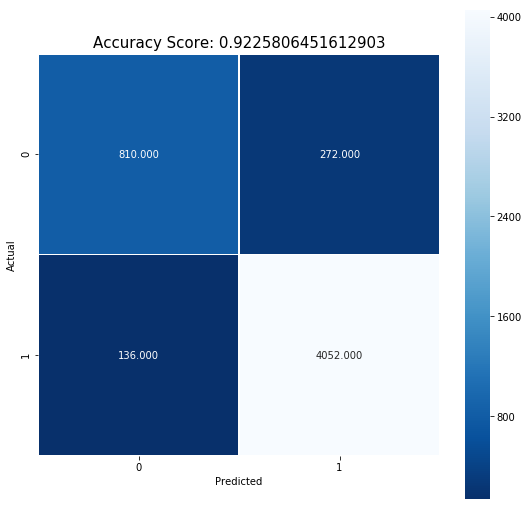

In [15]:
plot_confusion_matrix(model, x_train_vect.transform(X_test), Y_test, predictions)

### Accuracy vs. AUC

Accuracy and AUC both measure the performance of the classifier, but, the accuracy score does not take into account the classifier threshold and the AUC does. So AUC is a more complete measure of performance considering the data is roughly an ~80/20 split Positive/Negative.

This [article](http://fastml.com/what-you-wanted-to-know-about-auc/) explains AUC in detail.

> That’s another advantage of AUC over accuracy. In case your class labels are mostly negative or mostly positive, a classifier that always outputs 0 or 1, respectively, will achieve high accuracy. In terms of AUC it will score 0.5.

### Top Features

Print out the features with the smallest coefficients (most negative), and the features with the largest coefficients (most positive)

In [16]:
feature_names = np.array(x_train_vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:20]))
print('Largest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:-21:-1]))

Smallest Coef: 
['worst' 'terrible' 'awful' 'disappointing' 'unfortunately' 'horrible'
 'disappointed' 'the worst' 'not recommend' 'died' 'threw' 'would not'
 'weak' 'nasty' 'not worth' 'cancelled' 'very disappointed' 'stale'
 'popped' 'msg']

Largest Coef: 
['delicious' 'excellent' 'not too' 'perfect' 'great' 'amazing' 'wonderful'
 'awesome' 'yummy' 'good' 'glad' 'better than' 'pleased' 'is great'
 'smooth' 'best' 'rich' 'is the best' 'nice' 'easy to']



### Make a Prediction

Test the model with some custom review text

In [17]:
prediction_text = "I might get this candy again"
prediction = model.predict(x_train_vect.transform([prediction_text]))[0]

print("Text to predict:\n\n" + prediction_text + "\n")

if prediction:
    print("Prediction ==> POSITIVE")
else:
    print("Prediction ==> NEGATIVE")

Text to predict:

I might get this candy again

Prediction ==> POSITIVE


# Categorical Score Approach - Multinomial Logistic Regression

Create a new logistic regression, this time as a [multinomial logistic regression](https://en.wikipedia.org/wiki/Multinomial_logistic_regression) to spread the classifier across all 5 possible score values.

In [18]:
# Reset 'df' to the original 'review_data' to get back columns that were removed
df = load_data("Reviews.csv", 100000)
average_score = compute_avg(df)
print("Average Score: " + "{0:.2f}".format(average_score))

Average Score: 4.15


### Score Distribution

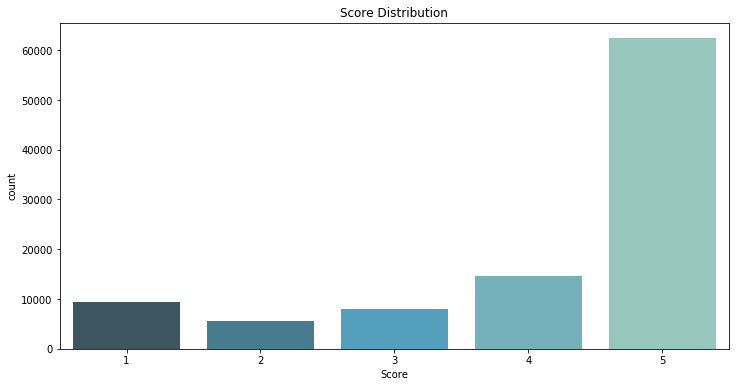

In [19]:
plt.subplots(figsize = (12,6))
countplot(df, 'Score', 'Score Distribution')

### Cleaning

In [20]:
df = df[df['HelpfulnessNumerator'] != 0]
df.drop(columns = DROP_COLS, inplace = True, axis = 1)
print("Number of rows: " + str(df.shape[0]))
df.head()

Number of rows: 46098


,Id,Score,Text
0,1,5,I have bought several of the Vitality canned d...
2,3,4,This is a confection that has been around a fe...
3,4,2,If you are looking for the secret ingredient i...
8,9,5,Right now I'm mostly just sprouting this so my...
10,11,5,I don't know if it's the cactus or the tequila...


### Split into Training and Test

Split into training and test sets using the text and score columns.

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(df['Text'], df['Score'], random_state = 0)
print('X_train row count: ', X_train.shape[0])
print('Y_train row count: ', Y_train.shape[0])

X_train row count:  34573
Y_train row count:  34573


### Features

Get the number of features being used by the vectorizer for the `X_train` set.

> **NOTE:** We're using the same vectorizer (`cv`) as for the logistic regression, but need to re-fit it to the new score training set.

In [22]:
x_train_vect = cv.fit(X_train)
print("Number of features in X_train: " + str(len(x_train_vect.get_feature_names())))

Number of features in X_train: 77544


### Create the Model

Create logistic regression model, run predictions, and compute the accuracy score:

**NOTE:** Must use a different solver than the default `liblinear` for the `sklearn.linear_model.LogisticRegression`, according to the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score):

> For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.

In [23]:
# Use the feature vector to transform the training and test sets - transforms documents
# into vectors of feature weights
X_train_vectorized = x_train_vect.transform(X_train)
X_test_vectorized = x_train_vect.transform(X_test)

# Create logistic regression model
#
# Options for solver: => ['newton-cg', 'sag', 'saga', 'lbfgs']
#
model = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')

# Train model with X & Y sets
model.fit(X_train_vectorized, Y_train)

# Create predections from test set
predictions = model.predict(x_train_vect.transform(X_test))
print('Score: ', model.score(X_test_vectorized, Y_test))

Score:  0.7277223427331887


### Confusion Matrix

Where the confusion matrix above showed only four quadrants representing true and false positives and negatives, this matrix shows the accuracy across all 5 categories.

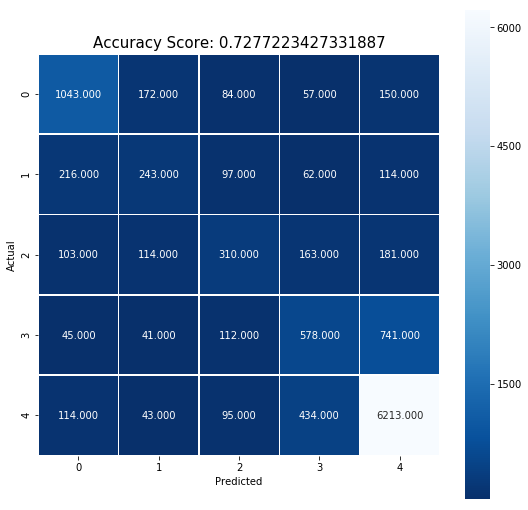

In [24]:
plot_confusion_matrix(model, x_train_vect.transform(X_test), Y_test, predictions)

The bottom right corner represents correctly predicted scores of 5. Since 5 scores represent a large proportion of the dataset, there are many more correctly predicted 5s than other scores.

### Top Features

Print out the features with the smallest coefficients (most negative), and the features with the largest coefficients (most positive)

In [25]:
feature_names = np.array(x_train_vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()
print('Smallest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:20]))
print('Largest Coef: \n{}\n'.format(feature_names[sorted_coef_index][:-21:-1]))

Smallest Coef: 
['delicious' 'stars' 'excellent' 'perfect' 'amazing' 'definitely' 'loves'
 'quickly' 'liked' 'wonderful' 'awesome' 'but not' 'easy' 'not too'
 'impressed' 'snack' 'they re' 'without' 'exactly' 'nice']

Largest Coef: 
['worst' 'horrible' 'terrible' 'disgusting' 'the worst' 'awful' 'at all'
 'yuck' 'nasty' 'money' 'threw' 'disappointed' 'sorry' 'return'
 'not recommend' 'stale' 'very disappointed' 't even' 'gross' 'poor']



### Make a Prediction

Test the model with some custom review text

In [26]:
prediction_text = "It was pretty good, I think I might order it again."
prediction = model.predict(x_train_vect.transform([prediction_text]))[0]

print("Text to predict:\n\n" + prediction_text + "\n")
print("Prediction ==> " + str(prediction))

Text to predict:

It was pretty good, I think I might order it again.

Prediction ==> 4
